In [69]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Load JSON files
us_json_path = "../resources/usCompanies.json"
foreign_json_path = "../resources/foreignCompanies.json"

with open(us_json_path, "r") as file:
    us_data = json.load(file)

with open(foreign_json_path, "r") as file:
    foreign_data = json.load(file)

In [71]:
# Extract stock tickers
us_tickers = list(us_data["2017-01-20_2017-12-31"].keys())
foreign_tickers = list(foreign_data["2017-01-20_2017-12-31"].keys())

In [73]:
# Function to extract price changes from JSON
def extract_prices(data, tickers, year):
    prices = {}
    for ticker in tickers:
        try:
            first_date = list(data[f"{year}-01-20_{year}-12-31"][ticker]["historical_prices"].keys())[0]
            last_date = list(data[f"{year}-01-20_{year}-12-31"][ticker]["historical_prices"].keys())[-1]
            prices[ticker] = {
                "Price Start": data[f"{year}-01-20_{year}-12-31"][ticker]["historical_prices"][first_date]["Close"],
                "Price End": data[f"{year}-01-20_{year}-12-31"][ticker]["historical_prices"][last_date]["Close"]
            }
        except KeyError:
            prices[ticker] = None
    return prices

In [75]:
# Extract stock prices for both years
us_prices_2017 = extract_prices(us_data, us_tickers, 2017)
us_prices_2021 = extract_prices(us_data, us_tickers, 2021)
foreign_prices_2017 = extract_prices(foreign_data, foreign_tickers, 2017)
foreign_prices_2021 = extract_prices(foreign_data, foreign_tickers, 2021)

In [77]:
# Create DataFrame
us_df = pd.DataFrame({
    "Ticker": us_tickers, "Region": "US", 
    "Price 2017": [us_prices_2017[t]["Price Start"] if t in us_prices_2017 and us_prices_2017[t] else None for t in us_tickers],
    "Price 2021": [us_prices_2021[t]["Price End"] if t in us_prices_2021 and us_prices_2021[t] else None for t in us_tickers]
})
foreign_df = pd.DataFrame({
    "Ticker": foreign_tickers, "Region": "International", 
    "Price 2017": [foreign_prices_2017[t]["Price Start"] if t in foreign_prices_2017 and foreign_prices_2017[t] else None for t in foreign_tickers],
    "Price 2021": [foreign_prices_2021[t]["Price End"] if t in foreign_prices_2021 and foreign_prices_2021[t] else None for t in foreign_tickers]
})

In [79]:
# Merge DataFrames
df = pd.concat([us_df, foreign_df], ignore_index=True)

# Calculate percentage change
df["% Change"] = ((df["Price 2021"] - df["Price 2017"]) / df["Price 2017"]) * 100

# Drop rows with missing values
df = df.dropna()

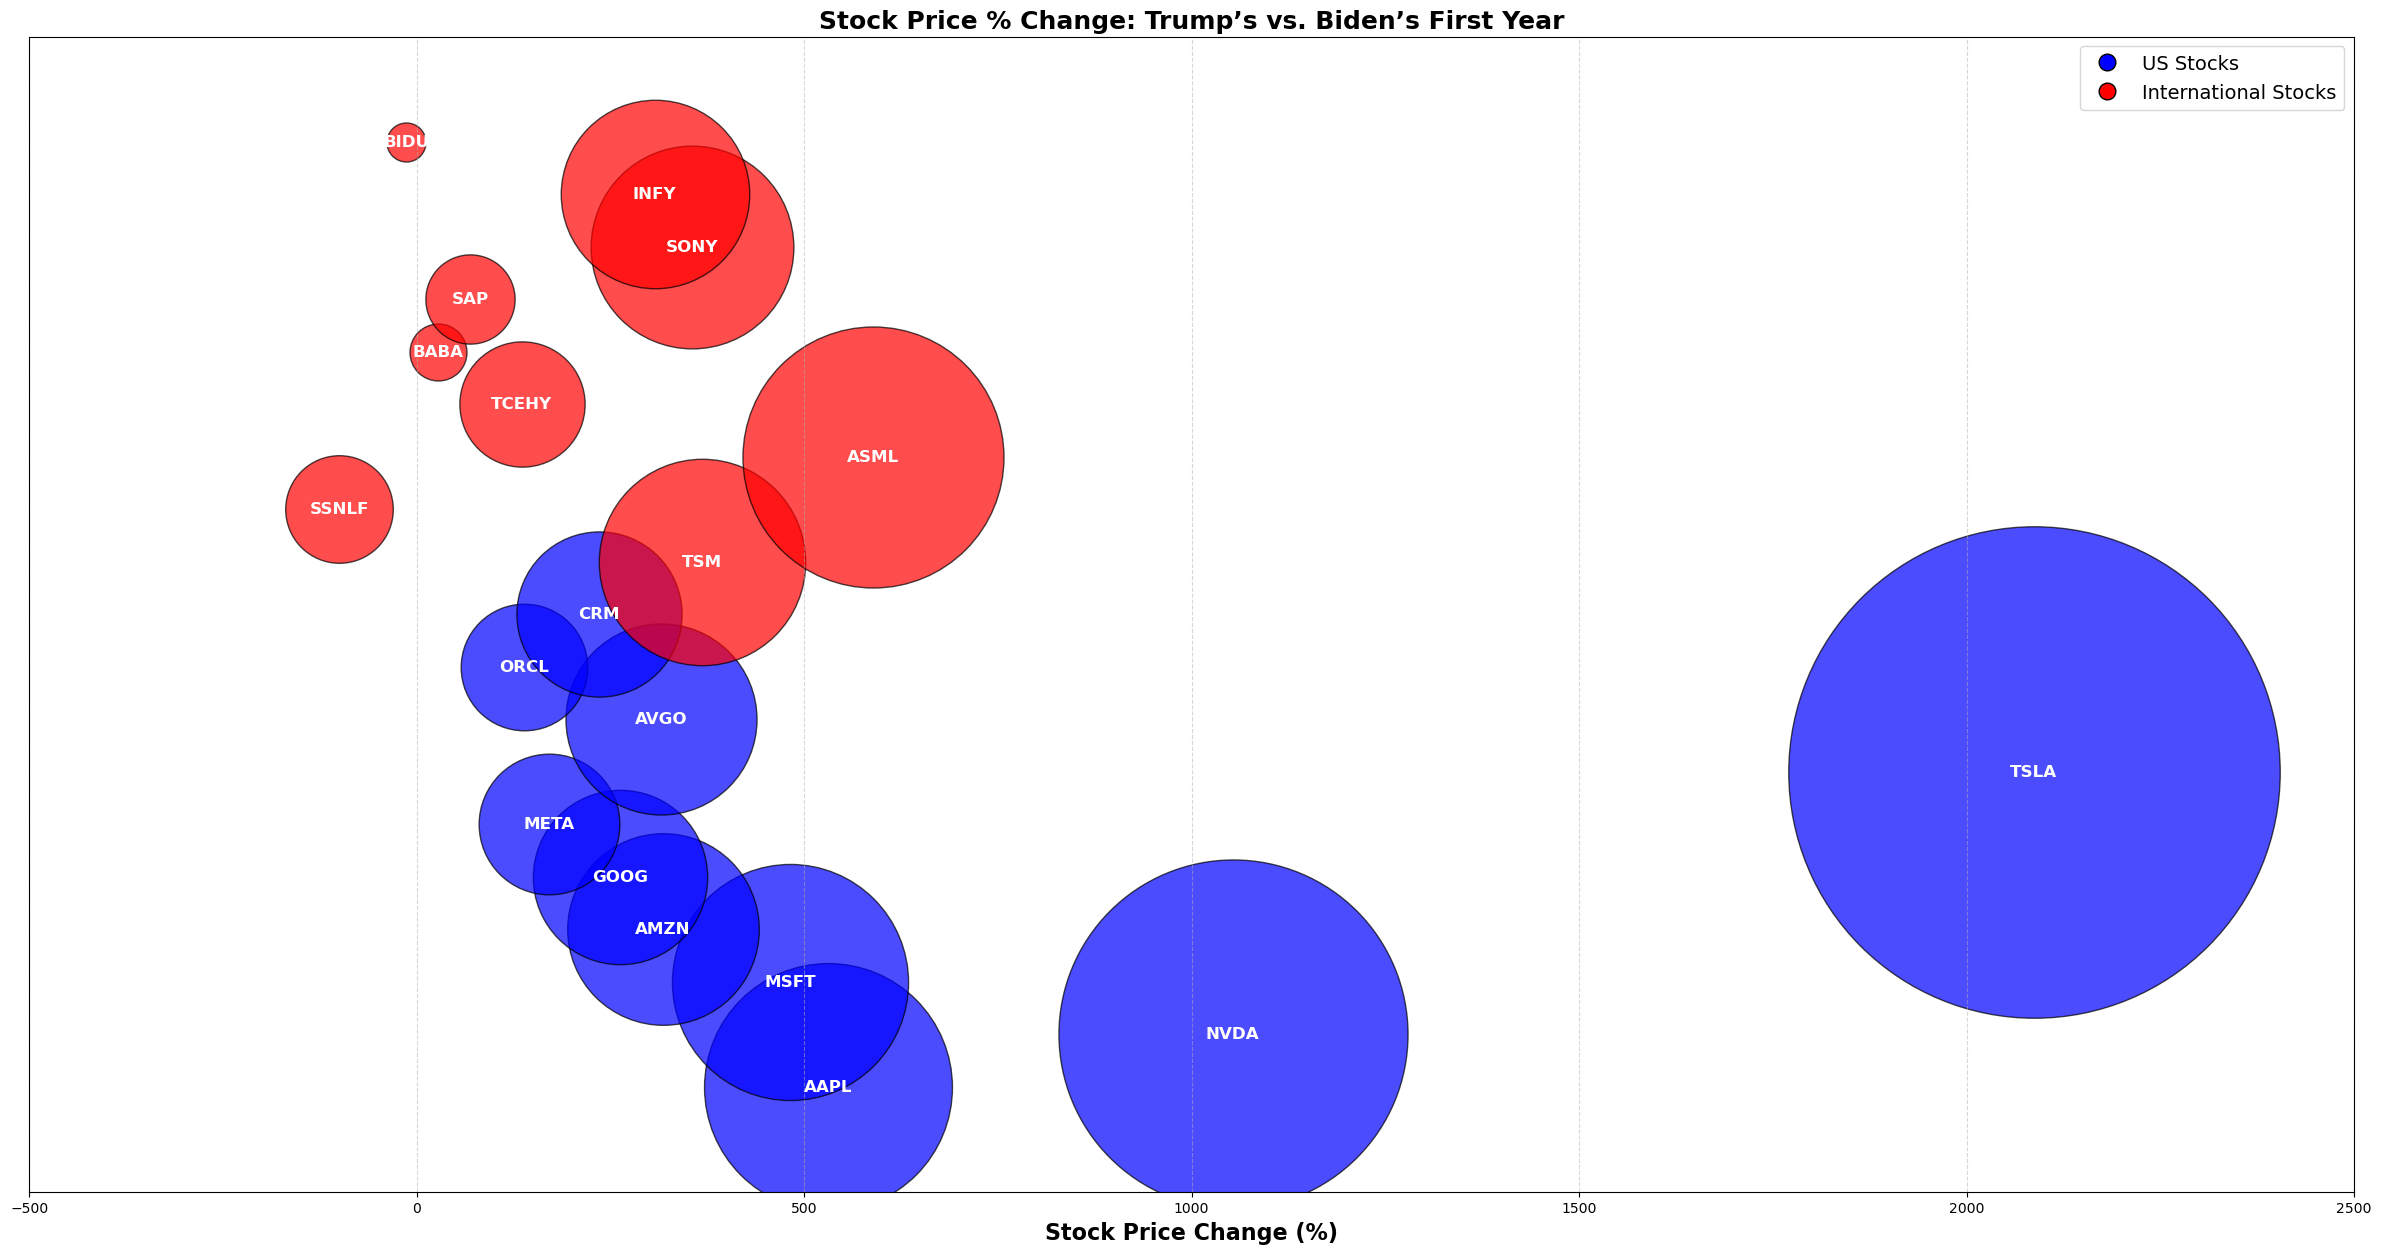

In [81]:
# Spread out the bubbles on the Y-axis to prevent overlap
df["y_offset"] = np.linspace(1, len(df), len(df))  

# Assign colors
colors = {"US": "blue", "International": "red"}
bubble_colors = [colors[region] for region in df["Region"]]

# Scale bubble sizes
sizes = abs(df["% Change"]) * 60  # Bigger bubbles for visibility

# Create a Larger Matplotlib Figure
fig, ax = plt.subplots(figsize=(30, 15))  # Increased size for clarity

# Plot bubbles
for i, (ticker, x, y, size, color) in enumerate(zip(df["Ticker"], df["% Change"], df["y_offset"], sizes, bubble_colors)):
    ax.scatter(x, y, s=size, color=color, edgecolors='black', alpha=0.7)
    ax.text(x, y, ticker, fontsize=12, ha='center', va='center', color='white', fontweight='bold')  # ✅ Centered text

# Labels and formatting
ax.set_xlabel("Stock Price Change (%)", fontsize=16, fontweight="bold")
ax.set_title("Stock Price % Change: Trump’s vs. Biden’s First Year", fontsize=18, fontweight="bold")
ax.set_yticks([])  # Hide y-axis labels
ax.grid(True, linestyle="--", alpha=0.5)


# Adjust X-axis to range from -3000 to 3000
ax.set_xlim(-500, 2500)

# Adjust Y-axis to ensure all bubbles fit
ax.set_ylim(0, 3000)  # Extend Y-axis to 3000

ax.set_ylim(df["y_offset"].min() - 2, df["y_offset"].max() + 2)  # Expand y-axis

# Custom legend for US vs. International stocks
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='US Stocks', markersize=12, markerfacecolor='blue', markeredgecolor="black"),
    Line2D([0], [0], marker='o', color='w', label='International Stocks', markersize=12, markerfacecolor='red', markeredgecolor="black")
]
ax.legend(handles=legend_elements, loc="upper right", fontsize=14)

plt.show()